# Building a monetization model

We have data in hand that contains information about the events in the mobile game. In it, users build their space program and try to accomplish the difficult task of colonizing the galaxy.

The main monetization of the game is just planned. However, it is assumed that the application will display ads on the screen with a choice of the type of object for construction.

The dataset contains data about the game of users on the first level. To reach the first level, the player must meet one of two conditions:

- Victory over the first opponent
- Project implementation - development of a satellite array in orbit

The dataset contains data on the first users of the application - a cohort of users who started using the application in the period from May 4 to May 10, inclusive.

Dataset `game_actions.csv`:

- `event_datetime` — event time
- `event` is one of three events:

1. `building` - the object is built
2. `finished_stage_1` - the first level is completed
3. `project` - the project is completed

- `building` - the object is built
- `finished_stage_1` - the first level is completed
- `project` - the project is completed
- `building_type` - one of three building types:

1. `assembly_shop` - assembly shop
2. `spaceport` - spaceport
3. `research_center` - research center

- `user_id` - user ID
- `project_type` — type of implemented project

In addition to the main dataset, there are two datasets with information about advertising activities.

The `ad_costs.csv` dataset contains the following columns:

- `day` - day on which the ad was clicked
- `source` - traffic source
- `cost` - cost of clicks

The `user_source.csv` dataset contains the following columns:

- `user_id` - user ID
- `source` - sources from which the user who installed the application came

## Loading and preparing data for analysis

In [ ]:
# import
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import datetime
import warnings
from scipy import stats as st

In [ ]:
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:

sourse = pd.read_csv('/var/user_source.csv')
actions = pd.read_csv('/var/game_actions.csv')
costs = pd.read_csv('/var/ad_costs.csv')

In [ ]:
sourse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


In [ ]:
sourse.sample(10)

,user_id,source
1915,227e63c4-f0bc-4a9a-ab8b-6d715b9d66a3,youtube_channel_reklama
12745,f02d39c1-909b-4b19-857e-01eda3305cae,yandex_direct
2121,264f146a-a765-4cab-b0fa-3c749be58387,youtube_channel_reklama
1638,1d770301-f896-4903-acbe-91b7a7756338,youtube_channel_reklama
8513,a08f4dc5-7b13-471e-bd55-731d1fb14bd1,yandex_direct
7091,84268230-7fe9-4a5d-83f1-f7b6ba4836f3,youtube_channel_reklama
7884,93fa487a-3a1f-4a82-b32b-3e9097fb6254,instagram_new_adverts
4500,533e2de8-37b8-401b-be44-e6d5dd45c5b4,facebook_ads
1476,1aa49d5d-76b9-4e31-89c3-af2af2cd1f0e,facebook_ads
1274,1796f107-9ff3-4048-92ed-a224d5844908,instagram_new_adverts


The `sourse` data frame contains data about the ad source from which the user came. At first glance, no errors were found in the data: The file type is correct, there are no gaps in the data, the information is presented in a readable form.

In [ ]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [ ]:
costs.sample(10)

,source,day,cost
19,yandex_direct,2020-05-08,62.96
10,instagram_new_adverts,2020-05-06,173.07
20,yandex_direct,2020-05-09,42.78
12,instagram_new_adverts,2020-05-08,71.58
15,yandex_direct,2020-05-04,554.65
17,yandex_direct,2020-05-06,180.92
5,facebook_ads,2020-05-08,68.01
23,youtube_channel_reklama,2020-05-05,147.04
4,facebook_ads,2020-05-07,111.77
26,youtube_channel_reklama,2020-05-08,40.22


The `cost` data frame contains data on advertising costs. No gaps were found in the data, but `day` column was not transferred to the correct data type.

In [ ]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [ ]:
actions.sample(10)

,event_datetime,event,building_type,user_id,project_type
6564,2020-05-04 19:32:23,building,assembly_shop,6d24a1b3-f66a-4cde-a956-af36862388d2,NaN
22234,2020-05-06 12:18:45,building,assembly_shop,e44f36e9-218e-4923-abbf-e559b30c0387,NaN
27921,2020-05-07 01:49:26,building,assembly_shop,026ab851-761f-4b67-91de-5e3e3851d5f9,NaN
123256,2020-05-17 18:54:11,finished_stage_1,NaN,f7ccaa16-2ed8-4609-9940-28a08938129f,NaN
90442,2020-05-12 11:34:47,building,spaceport,af3c66e9-b786-4daf-82de-977481c48ec8,NaN
100661,2020-05-13 19:23:12,building,spaceport,4302229f-87b1-4377-a5e8-0502875ca08d,NaN
21156,2020-05-06 09:44:16,building,assembly_shop,d672d6a7-9e40-4122-91f0-f94f0e67314e,NaN
34133,2020-05-07 15:31:57,building,assembly_shop,3f398fe2-b4f9-4ce3-9230-903cc771d493,NaN
35649,2020-05-07 18:56:36,building,spaceport,214e2fdd-ce9a-47b6-b8d8-4e6ac0e34508,NaN
104918,2020-05-14 09:33:16,building,spaceport,5626e601-4af7-4577-8b9b-8c0035f1ce60,NaN


The `action` data frame contains data about the game event and when the user executed it. There are gaps in the data, the `event_datetime` column is converted to the wrong data type, and to make the search easier we can select the date from this column separately.

In [ ]:
duplicate_costs = costs.duplicated().sum()
duplicate_actions = actions.duplicated().sum()
duplicate_sourse = sourse.duplicated().sum()

print(f'Number of duplicates in costs: {duplicate_costs}')
print(f'Percentage of duplicate costs: {round((duplicate_costs / len(costs))*100, 2)}%')
print('')
print(f'Number of duplicates in actions: {duplicate_actions}')
print(f'Percentage of duplicates in actions: {round((duplicate_actions / len(actions))*100, 2)}%')
print('')
print(f'Number of duplicates in sourse: {duplicate_sourse}')
print(f'Percentage of duplicates in sourse: {round((duplicate_sourse / len(sourse))*100, 2)}%')
print('')

print('Number of omissions in costs:', costs.isnull().sum())
print('Number of passes in actions:', actions.isnull().sum().sum())
print('Number of passes in sourse:', sourse.isnull().sum().sum())

Number of duplicates in costs: 0
Percentage of duplicate costs: 0.0%

Number of duplicates in actions: 1
Percentage of duplicates in actions: 0.0%

Number of duplicates in sourse: 0
Percentage of duplicates in sourse: 0.0%

Number of omissions in costs: source    0
day       0
cost      0
dtype: int64
Number of passes in actions: 141457
Number of passes in sourse: 0


In [ ]:
display('Unique sources from sourse:', sourse['source'].unique())
display('Unique traffic sources from costs:', costs['source'].unique())
display('Unique game events from actions:', actions['event'].unique())
display('Unique game buildings from actions:', actions['building_type'].unique())
display('Overview of cost per click values from costs:', costs['cost'].describe())

'Unique sources from sourse:'

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

'Unique traffic sources from costs:'

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

'Unique game events from actions:'

array(['building', 'finished_stage_1', 'project'], dtype=object)

'Unique game buildings from actions:'

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

'Overview of cost per click values from costs:'

count    28.00
mean    271.56
std     286.87
min      23.31
25%      66.75
50%     160.06
75%     349.03
max     969.14
Name: cost, dtype: float64

***Conclusion:***

Must do:
1. In `costs` table, change `day` column to `datetime` format;
2. In `actions` table, change `event_datetime` column to `datetime` format, check `building_type` and `project_type` columns for gaps and edit the duplicates found;
3. Select a separate date column from the `event_datetime` column in the `actions` table.

## Preparing data for analysis

### Changing Data Types

In [ ]:
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])
costs['day'] = pd.to_datetime(costs['day'])

### Check for duplicates

In [ ]:
actions[actions.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [ ]:
actions = actions.drop_duplicates()

### Create a new date column

In [ ]:
actions['date'] = actions['event_datetime'].dt.date.astype('datetime64')

### Work with gaps

In [ ]:
actions[actions['building_type'].isna()].head(10)

,event_datetime,event,building_type,user_id,project_type,date
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN,2020-05-04
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN,2020-05-05
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN,2020-05-05
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,2020-05-05
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN,2020-05-06
21293,2020-05-06 10:06:42,finished_stage_1,NaN,c1c8836d-7c6c-4839-90f7-04c9407a0b33,NaN,2020-05-06
22814,2020-05-06 13:43:12,finished_stage_1,NaN,2ab1cc5a-413a-408e-ba76-01de8e12bead,NaN,2020-05-06
24933,2020-05-06 18:54:42,finished_stage_1,NaN,d582f6e7-da7e-40c5-8534-a416b8685210,NaN,2020-05-06
29012,2020-05-07 04:15:34,finished_stage_1,NaN,399f918e-c8ea-4b90-900b-3c5c3f30fb54,NaN,2020-05-07
30111,2020-05-07 06:43:36,finished_stage_1,NaN,f50c1d40-8a18-43fe-b124-6892ac571cbf,NaN,2020-05-07


From the data received, it appears that the event '`finished_stage_1`' is characterized by gaps in the columns '`building_type`' and '`project_type`'. This is due to the way the client collects the data.

In the data frame, the data is collected in such a way that for each event (the '`event`' column) it is specified which building was built as a result of the event and which project was built as a result of this event, which means that for the event '`finished_stage_1`' the level ends, the user cannot build a building or perform a project.

The same scheme applies to the '`building`' event. There will be a gap in '`project_type`', the project will not run, but the building will be built. The same logic applies to the '`project`' event.

We will not touch these omissions, they are quite logical. But it is worth to check if there are gaps in the logic "building without building type" and "project without project type".

In [ ]:
actions.query('event == "building" and building_type.isna()')

,event_datetime,event,building_type,user_id,project_type,date


In [ ]:
actions.query('event == "building" and project_type.notna()')

,event_datetime,event,building_type,user_id,project_type,date


In [ ]:
actions.query('event == "project" and project_type.isna()')

,event_datetime,event,building_type,user_id,project_type,date


In [ ]:
actions.query('event == "project" and building_type.notna()')

,event_datetime,event,building_type,user_id,project_type,date


Checking for gaps in the data according to the logic "building without building type" and "project without project type" showed that no such gaps were found, which means that the data contain only gaps specific to the data collection method chosen by the client.

In [ ]:
# check
print('The number of duplicates in actions after processing:', actions.duplicated().sum())
print('')
print(actions.info())
print('')
print(costs.info())

The number of duplicates in actions after processing: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
 5   date            135639 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 7.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns]

***Conclusion***

During data processing, the following actions were performed:
- In the '`costs`" and '`actions`" tables, the '`day`' and '`event_datetime`' columns were changed to '`datetime`' format;
- In the "`actions`" table, a new '`date`' column was created to contain the date of the event;
- Elimination of duplicates and checking of gaps in all tables.

## Exploratory data analysis

### User analysis

In [ ]:
print('Number of users:', actions['user_id'].count())
print('Number of unique users:', actions['user_id'].nunique())

### Distribution of time in data

In [ ]:
print('Beginning of the actions table period: ', min(actions.event_datetime))
print('End of actions table period: ', max(actions.event_datetime))
print('Beginning of the period of the costs table: ', min(costs.day))
print('End of costs table period: ', max(costs.day))

Previously, the client had indicated that the dataset contained data from the first users of the application - a cohort of users who started using the application in the period from May 4 to May 10, inclusive, i.e. 13576 unique users.

Data on the events of these users are presented from May 4 to June 5.

The advertising campaign was conducted from May 3 to May 9.

The revealed dates do not collide with each other, the advertisement was purchased only for 6 days. Based on the data obtained, it can be assumed that the advertisement was purchased in advance (May 3), but in fact it was shown to users only on May 4. For this reason, the "delay" occurs on one day.

### Distribution of game events and game buildings

In [ ]:
def simple_plot(data, column, name, dpi=None, indent=1000, rot=None):
    '''
    график simple_plot, аргументы:
    data - датасет, column - столбец, name - имя графика,
    dpi - разрешение, indent - отступ значений от столбца,
    rot - наклон подписей оси Х.
    '''
    fig = plt.figure(figsize=(6,3), dpi=dpi)
    ax = sns.countplot(x = column,
                      data = data,
                      order = data[column].value_counts().index,
                      palette=['#e1958e', '#b6e7ec', '#f1caee', '#dde38b'])
    sns.despine(bottom=True)
    ax.set(xlabel=None)
    plt.xticks(rotation=rot)
    ax.set_title(name,
                 fontsize=15, color = '#000000', weight="bold", y=1.2)
    for i, count in enumerate(data[column].value_counts()):
        ax.text(i, count+indent, str(count) + ' (' + str(round(count/data[column].value_counts().sum()*100,2))+' %)',
                horizontalalignment='center', fontsize=10, color='black')
    plt.show() 

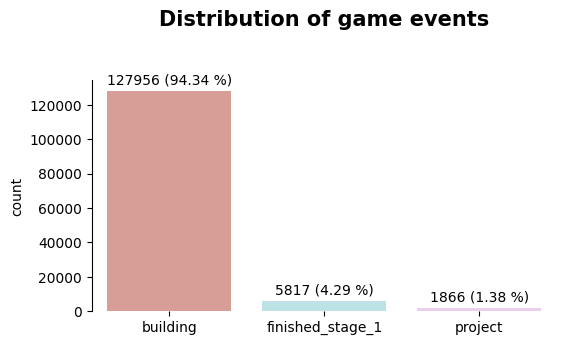

In [ ]:
simple_plot(actions, 'event', 'Distribution of game events', indent=4000)

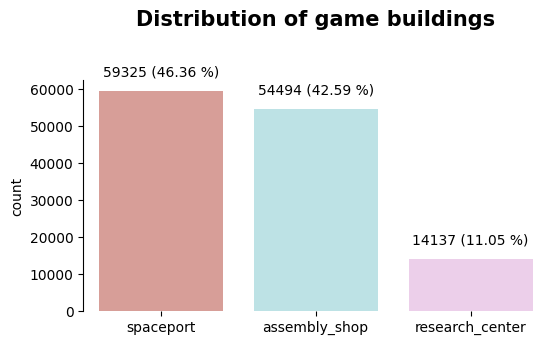

In [ ]:
simple_plot(actions, 'building_type', 'Distribution of game buildings', indent=4000)

Based on the aggregated data, the following conclusions can be drawn:

1. Almost 130k. (94%) of the events are described as 'building', i.e. the user is in the process of constructing a building. About 6k (4%) of users from the sample completed the first stage, 2k (1%) did so through project implementation.
2. Almost evenly distributed are building 'assembly_shop' (54k., 42%) and 'spaceport' (59k., 46%), 'research_center' built only 14k. (11%) of the users.

### Analysis of users who passed / did not pass to a new level

In [ ]:
new_lvl = pd.DataFrame(actions.user_id.unique())
new_lvl.columns = ['user_id']

In [ ]:
finish_lvl = actions.query('event == "finished_stage_1"')['user_id'].unique()
new_lvl['finish_lvl'] = new_lvl['user_id'].apply(lambda x: 1 if x in finish_lvl else 0)

finish_lvl_project = actions.query('event == "project"')['user_id'].unique()
new_lvl['finish_lvl_split'] = new_lvl['user_id'].apply(lambda x: 'project' if x in finish_lvl_project
                                                         else 'victory' if x in finish_lvl
                                                         else 'no_finish')

count_building = actions.query('event == "building"').groupby('user_id')\
                 .agg({'event':'count'}).reset_index().rename(columns={'event':'count_building'})
new_lvl = new_lvl.merge(count_building, how='left', on='user_id')

day1 = actions.groupby('user_id')['date'].first().reset_index().rename(columns={'date':'day1'})
new_lvl = new_lvl.merge(day1, how='left', on='user_id')

finish_lvl_day = actions.query(
    'event == "finished_stage_1"')[['user_id', 'date']].rename(columns={'date':'finish_lvl_day'})
new_lvl = new_lvl.merge(finish_lvl_day, how='left', on='user_id')

last_day = actions.groupby('user_id')['date'].last().reset_index().rename(columns={'date':'last_day'})
new_lvl = new_lvl.merge(last_day, how='left', on='user_id')

new_lvl['count_lvl_day'] = (new_lvl['finish_lvl_day']- new_lvl['day1']) / datetime.timedelta(days=1)

In [ ]:
new_lvl['total_day'] = (new_lvl['last_day']- new_lvl['day1'])/datetime.timedelta(days=1)

count_play_day = actions.groupby('user_id')['date'].nunique().reset_index().rename(columns={'date':'count_play_day'})
new_lvl = new_lvl.merge(count_play_day, how='left', on='user_id')

new_lvl = new_lvl.merge(sourse, how='left', on='user_id')

count_building_type = actions.groupby(['user_id', 'building_type'])['event_datetime'].count().reset_index()
count_building_type = count_building_type.pivot_table(
    index='user_id', columns='building_type', values='event_datetime').reset_index()
new_lvl = new_lvl.merge(
    count_building_type[['user_id','assembly_shop', 'spaceport', 'research_center']], how='left', on='user_id')

In [ ]:
new_lvl.sample(10)

,user_id,finish_lvl,finish_lvl_split,count_building,day1,finish_lvl_day,last_day,count_lvl_day,total_day,count_play_day,source,assembly_shop,spaceport,research_center
5817,55e6432b-3fa2-45e0-9bcd-7b82b0bfef6b,1,project,16,2020-05-04,2020-05-20,2020-05-20,16.00,16.00,11,yandex_direct,6.00,9.00,1.00
5886,f55e59f8-27c7-4c17-9b1c-9cfaab172402,1,victory,4,2020-05-05,2020-05-10,2020-05-10,5.00,5.00,3,yandex_direct,3.00,1.00,NaN
10972,8a003f28-6bfe-421e-883c-b5c065ef8aae,0,no_finish,5,2020-05-06,NaT,2020-05-13,NaN,7.00,5,yandex_direct,1.00,4.00,NaN
13028,608bc548-b4b2-4373-9d21-65819ec2ef28,0,no_finish,3,2020-05-09,NaT,2020-05-11,NaN,2.00,2,youtube_channel_reklama,1.00,2.00,NaN
6533,dcbb6425-cf11-44f0-a3ad-da172b9318de,1,project,13,2020-05-05,2020-05-22,2020-05-22,17.00,17.00,11,instagram_new_adverts,6.00,6.00,1.00
9824,d989680b-a360-4cc2-994d-88429673dcb1,0,no_finish,15,2020-05-06,NaT,2020-05-21,NaN,15.00,9,youtube_channel_reklama,5.00,8.00,2.00
1922,27091d58-18f2-4cd7-9cc2-eb0973a99930,1,victory,11,2020-05-04,2020-05-16,2020-05-16,12.00,12.00,10,yandex_direct,7.00,3.00,1.00
183,38c7ba7b-4500-4cf9-b730-366c4e91c553,1,victory,14,2020-05-04,2020-05-14,2020-05-14,10.00,10.00,7,instagram_new_adverts,5.00,8.00,1.00
7263,f6cbe6a7-670d-422d-a8e1-f69ccade2970,0,no_finish,11,2020-05-05,NaT,2020-05-16,NaN,11.00,8,yandex_direct,5.00,4.00,2.00
660,9979640f-f3ef-47fa-8107-67e69c8c9257,0,no_finish,9,2020-05-04,NaT,2020-05-16,NaN,12.00,7,instagram_new_adverts,6.00,3.00,NaN


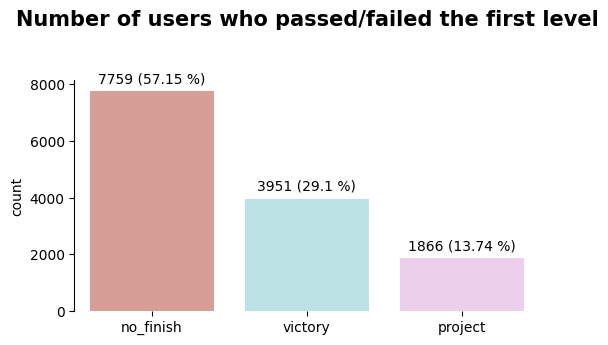

In [ ]:
simple_plot(new_lvl, 'finish_lvl_split', 'Number of users who passed/failed the first level', indent=300)

In [ ]:
simple_plot(new_lvl.query('finish_lvl == 1'), 'finish_lvl_split', 'Players who have completed the first level', indent=80)

From the data obtained, we can see the following:
- 57% of players did not complete the first level;
- 29% completed the first level by defeating the first opponent;
- 13.7% completed the first level by converting the project;
- The number of warriors (68%) is twice as high as that of builders (32%).

### Distribution of the number of `building` events by users

In [ ]:
def plotly_hist(data, column, name, name_x, name_y, color=None):
    '''
    график histogram, аргументы:
    data - датасет, column - столбец, name - имя графика, color - деление на группы.
    '''
    fig = px.histogram(data, x=column, color=color, barmode='group', width=800, height=400)
    fig.data[0].marker.color = '#e1958e'
    fig.update_layout(
                      plot_bgcolor='#f8f6f6',
                      title=dict(text='<b>{}</b>'.format(name), 
                                 font=dict(family="Arial",size=18,color='#344243'), x=0.5),
                      xaxis_title=dict(text='<b>{}</b>'.format(name_x)),
                      yaxis_title=dict(text='<b>{}</b>'.format(name_y))
                      )
    fig.show()

In [ ]:
plotly_hist(new_lvl, 'count_building', 'Distribution of the number of `building` events for each user', 
            'The number of `building` events', 'Number of users')

The average number of buildings per player is 10-11. The diagram shows a failure at 7 buildings, perhaps this is an easy phase in the game and it is quickly exceeded. This phase of the game can be used more effectively for advertising, because if a player has built 7 buildings, he will most likely build 8.

### Distribution the number of days to complete the first level by users

In [ ]:
plotly_hist(new_lvl, 'count_lvl_day', 'Distribution of the number of days to complete the first level', 
            'Number of days', 'Number od users')

There is a clear peak - 10-12 days - the time it takes users on average to complete the first level.

In [ ]:
plotly_hist(new_lvl, 'count_play_day', 'Distribution of the number of game days', 
            'Number of game days', 'Number of users', color='finish_lvl')

On average, during the presented period, players had 7-9 game days for those who completed the first stage and 4-8 for users who did not pass the first stage.

### Distribution of buildings over the time

In [ ]:
graph = new_lvl.merge(actions, how='left', on='user_id')
graph['days'] = (graph['date'] - graph['day1']) / datetime.timedelta(days=1)

In [ ]:
building_type = graph.groupby(['days', 'building_type'])['user_id'].count().reset_index()
fig = px.line(building_type,
              x='days',
              y='user_id',
              color='building_type',
              markers=True)
fig.update_layout(title='Distribution of buildings over the time',
                   xaxis_title='User game days',
                   yaxis_title='Number of buildings')
fig.show()

The analysis of the diagram shows the following:

- the first building of the users is `assembly_shop`, which is probably built by the players first and not for a long time, because you can immediately see a parallel upward trend to the construction of the `spaceport`;
- at the peak of the construction of the `spaceport`, the construction line of the `assembly_shop` breaks off. This could indicate that this building cannot be built after the construction of the `spaceport`;
- `research_center` the first active players built a few days later, the majority did so after about a week;
- in general, there is a decrease in building activity. This may indicate that the user either stopped building and left or moved to the next level.

### Distribution of advertising costs

In [ ]:
source_sum = costs.groupby('source')['cost'].sum().reset_index().sort_values('cost', ascending=False)
source_sum['%'] = source_sum['cost'] / source_sum.cost.sum() * 100
source_sum = round(source_sum, 1)
source_sum

In [ ]:
fig = px.bar(source_sum, x='source', y='cost', text='source', width=800, height=400)
fig.update_layout(
                 plot_bgcolor='#f8f6f6',
                 title=dict(text='<b>Distribution of costs by each source</b>',
                            font=dict(family="Arial",size=18,color='#344243'), x=0.5),
                 xaxis_title=dict(text='<b>Advertising source</b>'),
                 yaxis_title=dict(text='<b>Advertising costs</b>')
                 )
fig.data[0].marker.color = ['#c9f2cd', '#cdc9f2', '#f2c9ee', '#e9edb4']
fig.data[0].text = [str(i)+' ('+str(c)+' %)' for i,c in zip(source_sum['cost'], source_sum['%'])]
fig.show()

From the resulting diagram, it can be seen that the most money was spent on advertising in '`yandex_direct`' - 29%. The least money was spent on advertising in '`youtube_channel_reklama`' - only 14% of the total advertising costs. Advertising costs for other sources are approximately at the same level, namely in the range of 2140 - 2233 conventional units. (~28%)

Now let us look at these advertising costs per day, how evenly / unevenly the money was spent.

In [ ]:
fig = px.bar(costs, x='day', y='cost', color='source', barmode='group', width=900, height=500)
fig.update_layout(
                 plot_bgcolor='#f8f6f6',
                 title=dict(text='<b>Distribution of advertising costs by time and source </b>',
                            font=dict(family="Arial",size=18,color='#344243'), x=0.5),
                 xaxis_title=dict(text='<b>Date</b>'),
                 yaxis_title=dict(text='<b>Advertising costs</b>')
                 )
for i,c in zip(fig.data,['#a0e8a7', '#a7a0e8', '#e8a0e1', '#dde38b']):
    i.marker.color = c
fig.show()

The following conclusions can be drawn from the resulting diagram:
- most money was spent on advertising on the first day (May 3), totaling about 3302 conventional units;
- the costs decreased every day during the week, reaching the lowest values on May 9 - about 151 conventional units;
- for the expenses by sources, it is similar: the lowest costs are incurred for '`youtube_channel_reklama`', for the other sources the costs are approximately at the same level.

### Distribution of users by advertising sources

In [ ]:
simple_plot(sourse, 'source', 'Distribution of users by advertising sources', indent=150, rot=60)

From the resulting diagram, it can be seen that most users came from '`yandex_direct`' - about 35% of all attracted users, the least managed to attract through '`youtube_channel_reklama`' - about 19%. Other sources attracted on average 20-24% of users.

### Customer Acquisition Cost (САС)

In [ ]:
cac = sourse.groupby('source')['user_id'].count().reset_index()
cac = cac.merge(source_sum[['source','cost']], on='source')
cac['cac'] = round(cac['cost'] / cac['user_id'], 2)
cac = cac.sort_values('cac')
cac

Conclusions on the data:

- Users of the sources '`facebook_ads`' (CAC = 0.79) and 'instagram_new_adverts' (0.65) are the most expensive;
- The least is spent on the source '`youtube_channel_reklama`' (1068 units), its CAC index is the lowest - 0.47.

**Overall results of exploratory data analysis:**

The dataset contains data of the first users of the application - a cohort of users who started using the application from May 4 to May 10 inclusive, i.e. 13576 unique users. Data on the events of these users are presented from May 4 to June 5.
The advertising campaign was conducted from May 3 to May 9.

94% of the events are labelled as '`building`', i.e., the user is in the process of constructing a `building`.
Buildings of '`assembly_shop`' (54k., 42%) and '`spaceport`' (59k., 46%) were almost evenly distributed, '`research_center`' built only 14t. (11%) of the users.

57% of players did not finish the first level;
29% finished the first level by defeating the first opponent;
13.7% finished the first level by converting the project;
Warrior players (68%) are twice as likely as Builder players (32%).

The average number of buildings per player is 10-11. The data shows failure at 7 buildings, perhaps this is an easy level in the game and it is quickly passed.

Average time to complete the first level = 10-12 days. Users who failed the first level took an average of 4-8 days.

The first building of the user is '`assembly_shop`'.
The most money was spent on advertising in '`yandex_direct`' - 29%. The least was spent on advertising in '`youtube_channel_reklama`' - only 14% of the total advertising cost. Advertising costs for other sources are approximately at the same level, namely in the range of 2140 - 2233 conventional units. (~28%).

Most users came from '`yandex_direct`' - about 35% of all recruited users, the least of all managed to attract via '`youtube_channel_reklama`' - about 19%. Other sources attracted on average 20-24% of users.

Users of '`facebook_ads`' (CAC = 0.79) and '`instagram_new_adverts`' (0.65) are the most expensive;
The source '`youtube_channel_reklama`' spent the least (1068 units), its CAC index is the lowest - 0.47.

## Analysis of impact of events on the completion of the target event

It is worth noting that the target event for us is the **stage completion**, i.e. clicking the "Next" button, which generates the '`finish_stage_1`' event.

### Change in the values of the average number of buildings and the share of users who completed the first level by sources

In [ ]:
new_lvl.groupby(['source']).agg({'user_id':'count','count_building':'mean', 'finish_lvl':'mean'})

In general, according to the data, the averages of the number of buildings and the average proportions of users who completed the first stage under the sources do not vary significantly:
- The average number of buildings varies from 9.59 to 9.30;
- The average shares of the users who completed the first level varies in the diapason 0.42 to 0.44.

### Change of average values (number of buildings, time to pass the first level, the number of game days) in the context of the method of level completion

In [ ]:
new_lvl.groupby(['finish_lvl_split']).agg({'user_id':'count','count_building':'mean',
                                        'count_lvl_day':'mean', 'count_play_day':'mean',
                                        'assembly_shop':'mean', 'spaceport':'mean', 'research_center':'mean'})

On average, there is a clear trend: users who have completed the first level of the project take 2 days longer to complete the level (13.4) than players who have defeated the enemy (11), they also build more and spend more time in the game.

**Conclusion:**

1. The average values of changes in the number of constructions and shares of those who completed the first level are about the same and do not vary much: (constructions: 9.59-9.3, shares of those who completed the level: 0.42-0.44.
2. Users who completed the level spend more resources compared to the players who defeated the enemy (pass the level for 2 days longer (13.4), build more and spend more time in the game).

## Statistical hypothesis testing

The following hypothesis has already been given in the study, it will be tested: the hypothesis of the difference of average passing time between users who finish a level through the implementation of the project, and users who finish a level by defeating another player.

- **H0** = Difference in average level completion time between users who finish a level through project implementation and users who finish a level by defeating another player `no`
- **H1** = Difference in average level completion time between users who finish a level through project implementation and users who finish a level by defeating another player `yes`.

Hypotheses will be tested using Student's T-test, but before testing hypotheses compare the variance of the two samples separately, and if they differ by more than 5%, then we consider the difference significant and choose the test parameter `equal_var = False`.

In [ ]:
project = new_lvl.query('finish_lvl_split == "project"')['count_lvl_day']
victory = new_lvl.query('finish_lvl_split == "victory"')['count_lvl_day']

In [ ]:
print('The dispersions differ by ',round((100 - np.var(project, ddof=1)/np.var(victory, ddof=1)*100),2),'%')

There is a difference of more than 5%, so we choose the test parameter `equal_var = False`.

In [ ]:
alpha = 0.05 # the critical level of statistical significance

results = st.ttest_ind(project, victory, equal_var = False)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Reject null hypothesis, there is a difference between users")
else:
    print("Failed to reject the null hypothesis, there is no difference between users")

***Hypothesis confirmed - there are differences***. Those who choose to pass the first level by implementing a project - pass it for 2 days longer in comparison with those who passed the level by defeating the first enemy.

Now let's test the second hypothesis of the difference in the average time of passing the level by users depending on the advertising source.

- **H0** = Difference in the average time of passing the level by users depending on the advertising source `no`
- **H1** = Difference in average level completion time by users depending on advertising source `available`

Let's compare the sources with the highest level completion rate (`instagram_new_adverts` (44%)) and the lowest (`facebook_ads` (42%))

In [ ]:
insta = new_lvl.query(
    'source == "instagram_new_adverts" and (finish_lvl_split == "victory" or finish_lvl_split == "project")')['count_lvl_day']
facebook = new_lvl.query(
    'source == "facebook_ads" and (finish_lvl_split == "victory" or finish_lvl_split == "project")')['count_lvl_day']

In [ ]:
print('The dispersions differ by ',round((100 - np.var(insta, ddof=1)/np.var(facebook, ddof=1)*100),2),'%')

In [ ]:
alpha = 0.05

results = st.ttest_ind(insta, facebook)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Reject null hypothesis, there is a difference between users")
else:
    print("Failed to reject the null hypothesis, there is no difference between users")

**Hypothesis not confirmed - no differences found.**

**Conclusion:**

The proposed hypothesis about the difference in the average time to pass a level between users who finish a level through project implementation and users who finish a level by defeating another player, is confirmed. There is a difference: those who choose to complete the first level through realization of the project - pass it for 2 days longer in comparison with those who passed the level by defeating the first enemy.

The hypothesis that we formulated about the difference in the average time to pass the level by users, depending on the advertising source, on the contrary, was not confirmed.

## Building a monetization model

In accordance with the above research, let's formulate a monetization model.

In the basic monetization model, ads are shown every time the player chooses a type of object to build. The customer wants to know if it is possible to "reduce the advertising load" on the player.

Displaying advertising brings 0.07 units of profit. 

In the basic monetization model, advertising is shown each time the player chooses the type of object to build, i.e. we can say that in the basic model the player will be shown advertising as many times as he built objects. Let's consider the variant of showing advertising not from the very first construction, but later, so that the player could get used to the game without any extra load.

Let's calculate profit from each variant of advertising to the player and compare indicators.

First, let's calculate the Income for all users for each model.

In [ ]:
# grouping data by user
pivot = (
    graph.groupby('user_id').agg({'building_type':'count'})
    .reset_index().sort_values(by = 'building_type', ascending = False)
)
# profit per 1 ad impression
pivot['revenue'] = 0.07

# calculation of the conditions for showing advertising in each model (from the 1st and the 2nd construction) and profit for each model
pivot['basic_model'] = pivot['building_type']
pivot['basic_model_revenue'] = pivot['basic_model'] * pivot['revenue']
pivot['model1'] = pivot['building_type'] - 1
pivot['model1'] = np.where((pivot.model1 < 0), 0, pivot.model1)
pivot['model1_revenue'] = pivot['model1'] * pivot['revenue']
pivot['model2'] = pivot['building_type'] - 2
pivot['model2'] = np.where((pivot.model2 < 0), 0, pivot.model2)
pivot['model2_revenue'] = pivot['model2'] * pivot['revenue']
display(pivot)

# Calculation of the total Revenue from advertising for each model
basic_model_revenue_total = round(pivot['basic_model_revenue'].sum(),2)
model1_revenue_total = round(pivot['model1_revenue'].sum(),2)
model2_revenue_total = round(pivot['model2_revenue'].sum(),2)

print('Income from the basic model (advertising from the first building):', basic_model_revenue_total)
print('Income from model 1 (advertising from the second building)', model1_revenue_total)
print('Income from model 2 (advertising from the third construction)', model2_revenue_total)

In [ ]:
# calculating the total cost of user engagement
n_users = actions.user_id.nunique()
print('Total users attracted: ', n_users)
sum_costs = round(costs.cost.sum(),2)
print('Total costs for attracting users: ', sum_costs)
print('')

# calculation of profit (income minus expenses) for each model
print('Basic model profit:', round(basic_model_revenue_total - sum_costs, 2))
print('Model 1(advertising from the side of the building) profit:', round(model1_revenue_total - sum_costs,2))
print('Model 2(advertising from the third building) profit:', round(model2_revenue_total - sum_costs,2))

basic = round(basic_model_revenue_total - sum_costs, 2)
model1 = round(model1_revenue_total - sum_costs,2)
model2 = round(model2_revenue_total - sum_costs,2)

In the end, after all the calculations we got:

In [ ]:
print(f'Base model (display advertising from the 1st construction), the income is: {basic_model_revenue_total}, advertising costs equal: {sum_costs}, profit: {basic}')
print(f'Model1 (display advertising from the 2nd construction), income is: {model1_revenue_total}, advertising costs equal: {sum_costs}, profit: {model1}')
print(f'Model2 (display advertising from the 3rd construction), income is: {model2_revenue_total}, advertising costs equal: {sum_costs}, profit: {model2}')

According to the data obtained, the situation is as follows:

Payback for 2 models out of the 3 considered:
   - Basic model (display advertising from the 1st construction), profit including expenses is 1353.34
   - Model 1 (display advertising from the 2nd construction), profit is 403.02
   - Model 2(display ads from the 3rd construction) does not pay off.
   
**Conclusion:**

Thus, we can optimize the basic customer monetization model by reducing the number of ad impressions, namely to start displaying ads from the player's 2nd construction under Model 1.

## General conclusions and recommendations

** Conclusions:**

1. Dataset contains data of the first users of the application - the cohort of users who started using the application from May 4 to 10 inclusive, which is 13576 unique users. The event data of these users is presented from May 4 to June 5.
2. An advertising campaign was conducted from May 3 to 9.
3. 94% of events are named as `building`, i.e. the user is in the process of building some structure. 
4. Almost equally distributed were the construction of `assembly_shop` (54k., 42%) and `spaceport` (59k., 46%), `research_center` built only 14t. (11%) users.
5. 57% of players did not complete the first level; 29% completed the first level by defeating the first enemy; 13.7% completed the first level by implementing the project.
6. Warrior players (68%) are twice as many as builder players (32%).
7. Average number of builds per player - 10-11.
8. Average time of passing the first level = 10-12 days. Users who did not pass the first level had an average of 4-8 days.
9. The first building of the users - `assembly_shop`, in parallel with the trend to the construction of the object `spaceport`. At the peak of the construction of `spaceport`, the construction line of `assembly_shop` breaks off. In general, there is a drop in construction activity after a week of play. This may indicate that either the user has stopped progress and left, or has moved on to the next level.
10. The most money was spent on advertising in `yandex_direct` - 29%. The least amount of money was spent on advertising in `youtube_channel_reklama` - only 14% of all advertising costs. Advertising costs from other sources are approximately at the same level, namely in the range from 2140 to 2233 cc. (~28%).
The most number of users came from `yandex_direct` - about 35% of all users involved, the least number of users was attracted with the help of `youtube_channel_reklama` - about 19%. The other sources attracted an average of 20-24% of users.
12. The most expensive are users from the sources `facebook_ads` (CAC = 0.79) and `instagram_new_adverts` (0.65).
13. The least spent on the source `youtube_channel_reklama` (1068 units), the index CAC it the least - 0.47.
14. Average number of constructions (9.3-9.6) and a share completed the first level (0.42-0.44) by sources, which came from the user about the same.
15. On average, who completed the first level of the project, pass the level for 2 days longer (13.4) than the players who defeated the enemy (11), also they build more and spend more time in the game.

The proposed hypothesis *about the difference in average level completion time between users who finish a level through project implementation and users who finish a level by defeating another player*, **is confirmed**. There is a difference: those who choose to complete the first level through realization of the project take 2 days longer to complete the level in comparison with those who completed the level by defeating the first enemy.

The hypothesis we formulated *about the difference in the average time for users to pass the level depending on the advertising source*, on the contrary, **was not confirmed**.

As part of the optimization of the monetization model, we calculated several options for reducing the advertising load on the user, and chose a suitable option: reducing the number of ad impressions, namely, starting to show ads from the player's second building in the game.

Basic model (advertising from the 1st creation), profit including expenses is 1353.34
Model 1 (display advertising from the 2nd building), profit is 403.02

## Building a dashboard

link:

https://public.tableau.com/views/games_16751077204130/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link